In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
from active_learning import ActiveLearner, Oracle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# animation
from matplotlib import animation
from celluloid import Camera

# preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# classification
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# data
from sklearn.datasets import fetch_20newsgroups

# Ennoncé
Le travail consiste à implémenter un algorithme d’active learning pour la classification de textes selon le pseudo-code
ci-dessous :

Input : ensemble de données étiquetées L, et ensemble de données non étiquetées U

Output : ensemble de données étiquetées L UNION U

Tant que U non vide
1. Entraîner un classifieur C (par exemple, un simple classifieur bayesien naif) en utilisant L
2. Utiliser C pour prédire les données U
3. Sélectionner dans U n instances et former un ensemble I contenant ces instances
4. Demander à l’expert d’étiqueter I
5. Faire L = L UNION I et U = U MOINS I
L’expert devra être simulé par le programme.

La technique de sélection utilisée au point 3 sera l'Uncertainty Sampling.
On utilisera les algorithmes de classification implémentés dans Scikit.

A chaque étape on affichera une métrique d’évaluation (utilisant les implémentation de Scikit).
Les données à utiliser sont :

le sous-ensemble NG5 du corpus NG20 accessible via Scikit.

NG5 comprend les classes :
'rec.motorcycles',
'rec.sport.baseball',
'comp.graphics',
'sci.space',
'talk.politics.mideast'

Le corpus Classic3 accessible à l’adresse :
https://mycloud.mi.parisdescartes.fr/s/HwpG4bmaRp3sSCC
ATTENTION : pour NG5, on utilisera l’option remove=('headers', 'footers', 'quotes') pour une évaluation plus réaliste

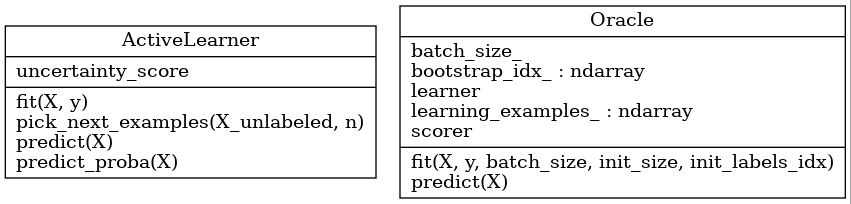

In [3]:
def anim_to_html(anim):
    plt.close(anim._fig)
    return anim.to_html5_video()

animation.Animation._repr_html_ = anim_to_html

In [4]:
def draw_choice(X, y, chosen, ax, i, first=-1):
    choice = pd.DataFrame({'chosen': chosen})
    target = pd.DataFrame({'classe': y})
    sns.scatterplot(X[:,0], X[:,1],
                    ax=ax,
                    hue=target.classe, palette='tab10',
                    style=choice.chosen,
                    markers={True: 'o', False: 'X'},
                    legend='full' if i==first else None)
    if i == first:
        ax.legend(loc='center left', 
                  bbox_to_anchor=(1.01,.5))

In [5]:
def animate_choices(X, y, choice_order, interval=200):
    fig = plt.figure(figsize=(10,5))
    
    # to avoid the legend being clipped
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.9]) # [left, bottom, width, height]
    
    camera = Camera(fig)
    chosen = np.zeros(choice_order.shape, dtype=bool)
    
    for it in range(-1, choice_order.max()+1):
        chosen |= (choice_order == it)
        draw_choice(X, y, chosen, ax, it)
        camera.snap()
    
    return camera.animate(interval=interval)

## Utilisation de données simples

In [6]:
sample = pd.read_csv('./sample_data/Aggregation.txt', sep='\t', header=None, names=['x1','x2','y'])
sample.head()

,x1,x2,y
0,15.55,28.65,2
1,14.90,27.55,2
2,14.45,28.35,2
3,14.15,28.80,2
4,13.75,28.05,2


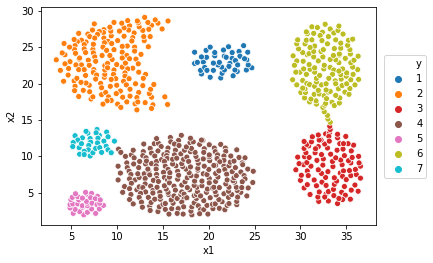

In [7]:
ax = sns.scatterplot(sample.x1, sample.x2,
                hue=sample.y, palette='tab10',
                legend='full')
ax.legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [8]:
X = sample[['x1', 'x2']].values
y = sample.y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)

In [9]:
classifier = LogisticRegression
clf_params = dict(solver='lbfgs', multi_class='auto', max_iter=100)
batch_size = 10

In [10]:
lc_learner = ActiveLearner(classifier(**clf_params), strategy='least_conf')
lc_oracle = Oracle(lc_learner, metrics=[precision_score, recall_score, f1_score])
lc_oracle.fit(X_train, y_train, X_test, y_test, batch_size=batch_size, init_size=20)

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

In [11]:
init_idx = lc_oracle.time_chosen_ == -1

In [12]:
margin_learner = ActiveLearner(classifier(**clf_params), strategy='margin')
margin_oracle = Oracle(margin_learner, metrics=[precision_score, recall_score, f1_score])
margin_oracle.fit(X_train, y_train, X_test, y_test, batch_size=batch_size, init_labels_idx=init_idx)

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

In [13]:
entropy_learner = ActiveLearner(classifier(**clf_params), strategy='entropy')
entropy_oracle = Oracle(entropy_learner, metrics=[precision_score, recall_score, f1_score])
entropy_oracle.fit(X_train, y_train, X_test, y_test, batch_size=batch_size, init_labels_idx=init_idx)

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

In [14]:
rand_learner = ActiveLearner(classifier(**clf_params), strategy='random')
rand_oracle = Oracle(rand_learner, metrics=[precision_score, recall_score, f1_score])
rand_oracle.fit(X_train, y_train, X_test, y_test, batch_size=batch_size, init_labels_idx=init_idx)

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

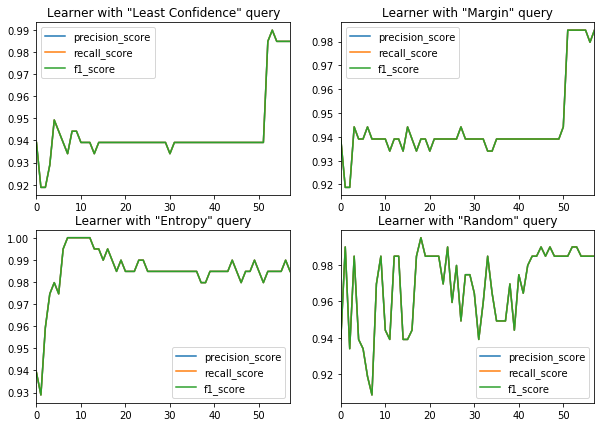

In [15]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(221)
lc_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Least Confidence" query')
ax = plt.subplot(222)
margin_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Margin" query')
ax = plt.subplot(223)
entropy_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Entropy" query')
ax = plt.subplot(224)
rand_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Random" query');

In [16]:
choice_order = lc_oracle.time_chosen_ 
choice_order[choice_order != -1] = choice_order[choice_order != -1] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, interval=500)
anim

In [17]:
choice_order = rand_oracle.time_chosen_
choice_order[choice_order != -1] = choice_order[choice_order != -1] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, interval=500)
anim

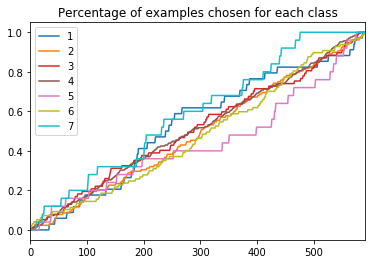

In [18]:
labels = np.unique(y_train)
classes = np.arange(labels.shape[0])
class_mat = np.zeros((y_train.shape[0], classes.shape[0]), dtype=bool)
for c in classes:
    class_mat[:, c] = y_train == labels[c]

class_counts = class_mat.sum(axis=0)
df_classes = pd.DataFrame(class_mat, columns=labels)

percent_chosen = df_classes.cumsum(axis=0)/class_counts
ax = percent_chosen.plot(cmap='tab10')
ax.set_title('Percentage of examples chosen for each class');

## Données NG5

In [19]:
categories = ['rec.motorcycles', 'rec.sport.baseball',
                'comp.graphics', 'sci.space',
                'talk.politics.mideast']
remove = ("headers", "footers", "quotes")
ng5_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
ng5_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)